Train shape: (9864, 58)
Test shape: (2466, 58)
Class distribution (train):
Revenue
False    0.845296
True     0.154704
Name: proportion, dtype: float64

Baseline decision tree
Tree depth: 42
Number of leaves: 1741

Performance (train)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC-AUC: 1.0
PR-AUC: 1.0

Performance (test)
Accuracy: 0.7623682076236821
Precision: 0.23711340206185566
Recall: 0.24083769633507854
F1: 0.23896103896103896
ROC-AUC: 0.5494015736953703
PR-AUC: 0.17470519669874407

Confusion matrix:
 [[1788  296]
 [ 290   92]]

Classification report:
               precision    recall  f1-score   support

       False       0.86      0.86      0.86      2084
        True       0.24      0.24      0.24       382

    accuracy                           0.76      2466
   macro avg       0.55      0.55      0.55      2466
weighted avg       0.76      0.76      0.76      2466


 Tuned Decision Tree (pre-pruning)
Best params: {'class_weight': 'balanced', 'max_depth': 9, 'min_sampl

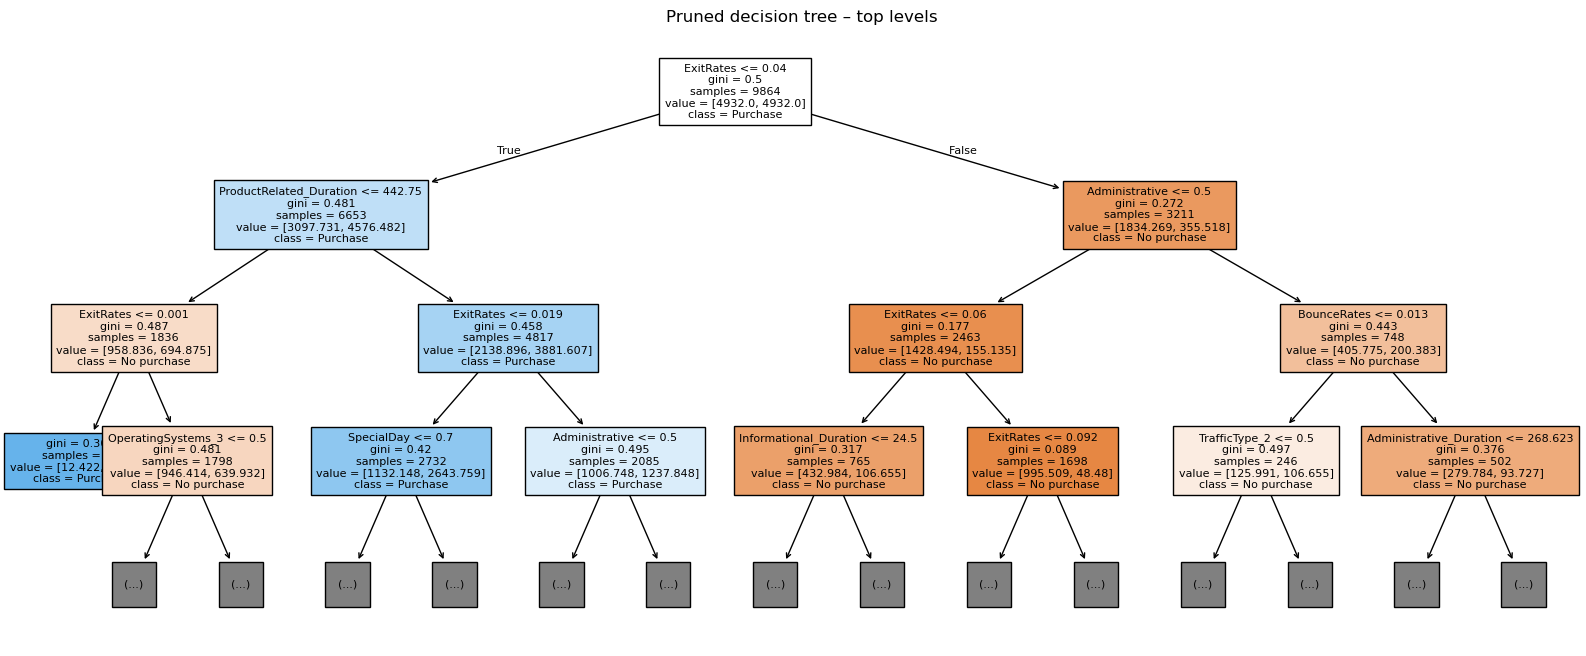

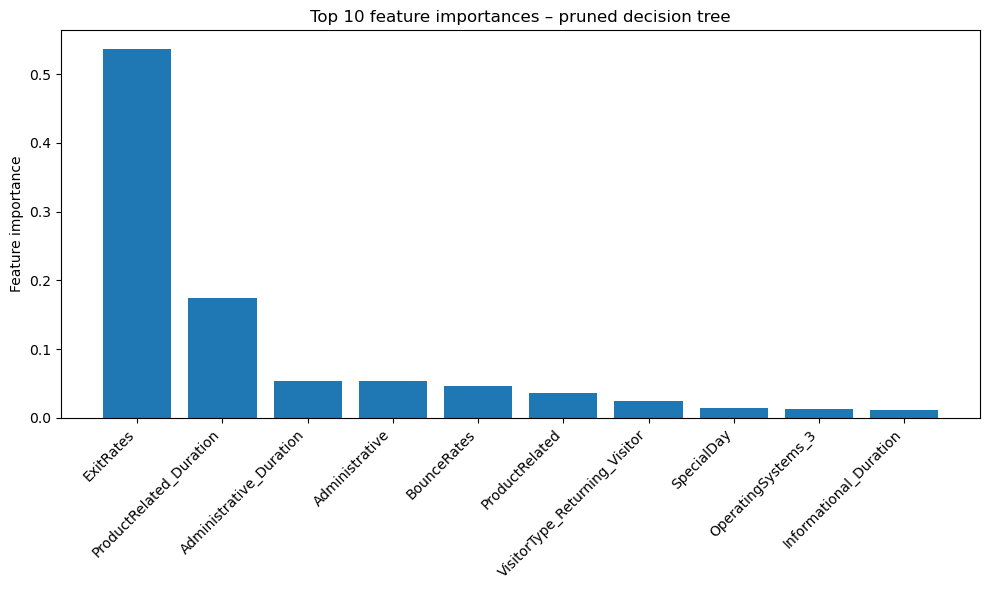

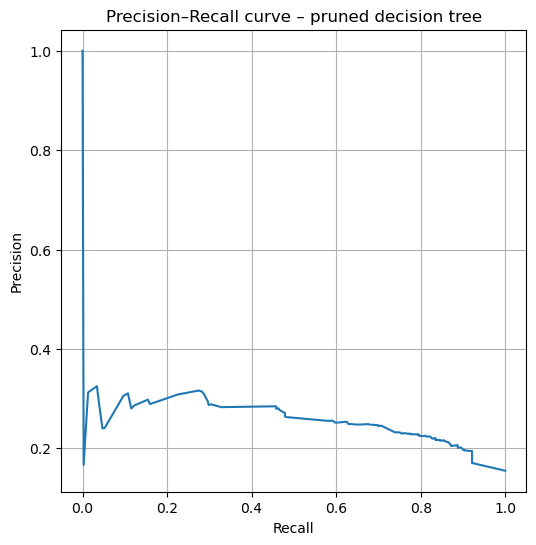

Exception ignored in: <function ResourceTracker.__del__ at 0x104ea0cc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1079bccc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exceptio

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)


# Helpers

def evaluate_classifier(model, X_train, y_train, X_test, y_test, name="Model"):
    """Print train + test diagnostics + tree complexity (if applicable)."""
    print(f"\n{name}")

    # Tree complexity if available
    if hasattr(model, "get_depth") and hasattr(model, "get_n_leaves"):
        print("Tree depth:", model.get_depth())
        print("Number of leaves:", model.get_n_leaves())

    # Train
    y_pred_tr = model.predict(X_train)
    y_proba_tr = model.predict_proba(X_train)[:, 1]
    print("\nPerformance (train)")
    print("Accuracy:", accuracy_score(y_train, y_pred_tr))
    print("Precision:", precision_score(y_train, y_pred_tr, zero_division=0))
    print("Recall:", recall_score(y_train, y_pred_tr, zero_division=0))
    print("F1:", f1_score(y_train, y_pred_tr, zero_division=0))
    print("ROC-AUC:", roc_auc_score(y_train, y_proba_tr))
    print("PR-AUC:", average_precision_score(y_train, y_proba_tr))

    # Test
    y_pred_te = model.predict(X_test)
    y_proba_te = model.predict_proba(X_test)[:, 1]
    print("\nPerformance (test)")
    print("Accuracy:", accuracy_score(y_test, y_pred_te))
    print("Precision:", precision_score(y_test, y_pred_te, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred_te, zero_division=0))
    print("F1:", f1_score(y_test, y_pred_te, zero_division=0))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba_te))
    print("PR-AUC:", average_precision_score(y_test, y_proba_te))

    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_te))
    print("\nClassification report:\n", classification_report(y_test, y_pred_te, zero_division=0))

    return y_pred_te, y_proba_te


def plot_pr_curve(y_true, y_proba, title):
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_feature_importances(model, feature_names, top_n=10, title="Feature importances"):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances[idx])
    plt.xticks(range(top_n), np.array(feature_names)[idx], rotation=45, ha="right")
    plt.ylabel("Feature importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_top_tree_levels(model, feature_names, max_depth=3, title="Decision tree (top levels)"):
    plt.figure(figsize=(20, 8))
    tree.plot_tree(
        model,
        feature_names=feature_names,
        class_names=["No purchase", "Purchase"],
        filled=True,
        max_depth=max_depth,
        fontsize=8
    )
    plt.title(title)
    plt.show()

X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
y_train = pd.read_csv("../Data/Processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").squeeze()

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class distribution (train):")
print(y_train.value_counts(normalize=True))


# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_baseline = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=None
)
dt_baseline.fit(X_train, y_train)

y_pred_base, y_proba_base = evaluate_classifier(
    dt_baseline, X_train, y_train, X_test, y_test, name="Baseline decision tree"
)


# Pre-pruning via GridSearchCV (optimized PR-AUC)

param_grid_dt = {
    "max_depth": [3, 5, 7, 9, 12],
    "min_samples_split": [2, 10, 20, 50],
    "min_samples_leaf": [1, 5, 10, 20],
    "class_weight": [None, "balanced"]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring="average_precision",  
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_dt.fit(X_train, y_train)

print("\n Tuned Decision Tree (pre-pruning)")
print("Best params:", grid_dt.best_params_)
print("Best CV PR-AUC:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
best_dt.fit(X_train, y_train)

y_pred_tuned, y_proba_tuned = evaluate_classifier(
    best_dt, X_train, y_train, X_test, y_test, name="Tuned decision tree (pre-pruned)"
)


print("\nCost-complexity pruning (post-pruning)")

# tuned hyperparams
base_params = best_dt.get_params()
base_params["ccp_alpha"] = 0.0

base_tree = DecisionTreeClassifier(**base_params)
base_tree.fit(X_train, y_train)

path = base_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(path.ccp_alphas)


if len(ccp_alphas) > 1:
    ccp_alphas = ccp_alphas[:-1]

print("Number of candidate alphas:", len(ccp_alphas))

pruned_cv_scores = []
for alpha in ccp_alphas:
    pruned = clone(base_tree)
    pruned.set_params(ccp_alpha=float(alpha))

    scores = cross_val_score(
        pruned,
        X_train,
        y_train,
        cv=cv,
        scoring="average_precision",
        n_jobs=-1
    )
    pruned_cv_scores.append(scores.mean())

best_alpha_index = int(np.argmax(pruned_cv_scores))
best_alpha = float(ccp_alphas[best_alpha_index])

print("Best alpha (ccp_alpha):", best_alpha)
print("Best CV PR-AUC with pruning:", pruned_cv_scores[best_alpha_index])

pruned_dt = clone(base_tree)
pruned_dt.set_params(ccp_alpha=best_alpha)
pruned_dt.fit(X_train, y_train)

y_pred_pruned, y_proba_pruned = evaluate_classifier(
    pruned_dt, X_train, y_train, X_test, y_test, name="Post-pruned decision tree (ccp_alpha)"
)


# 

plot_top_tree_levels(
    pruned_dt,
    feature_names=X_train.columns,
    max_depth=3,
    title="Pruned decision tree – top levels"
)

plot_feature_importances(
    pruned_dt,
    feature_names=X_train.columns,
    top_n=10,
    title="Top 10 feature importances – pruned decision tree"
)

plot_pr_curve(
    y_test,
    y_proba_pruned,
    title="Precision–Recall curve – pruned decision tree"
)